In [1]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab

In [2]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [3]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [4]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [40]:
class TSNE:
    def __init__(self, X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
        
        if isinstance(no_dims, float):
            print("Error: array X should have type float.")
        if round(no_dims) != no_dims:
            print("Error: number of dimensions should be an integer.")


        # Initialize variables
        (self.no_dims, self.initial_dims, self.perplexity) = (no_dims, initial_dims, perplexity)
        self.X = pca(X, initial_dims).real
        (self.n, self.d) = X.shape
        self.max_iter = 1000
        self.initial_momentum = 0.5
        self.final_momentum = 0.8
        self.eta = 500
        self.min_gain = 0.01
        self.Y = np.random.randn(self.n, no_dims)
        self.dY = np.zeros((self.n, no_dims))
        self.iY = np.zeros((self.n, no_dims))
        self.gains = np.ones((self.n, no_dims))

        # Compute P-values
        P = x2p(self.X, 1e-5, self.perplexity)
        P = P + np.transpose(P)
        P = P / np.sum(P)
        P = P * 4.									# early exaggeration
        self.P = np.maximum(P, 1e-12)
        self.embeddings_before_mmd = []
        self.embeddings_after_mmd = []
        self.ce_loss = []
        self.mmd_loss = []
    
    def _update(self, iter):
        
        # Compute pairwise affinities
        sum_Y = np.sum(np.square(self.Y), 1)
        num = -2. * np.dot(self.Y, self.Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(self.n), range(self.n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = self.P - Q
        for i in range(self.n):
            self.dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (self.no_dims, 1)).T * (self.Y[i, :] - self.Y), 0)

        # Perform the update
        if iter < 20:
            momentum = self.initial_momentum
        else:
            momentum = self.final_momentum
        self.gains = (self.gains + 0.2) * ((self.dY > 0.) != (self.iY > 0.)) + \
                (self.gains * 0.8) * ((self.dY > 0.) == (self.iY > 0.))
        self.gains[self.gains < self.min_gain] = self.min_gain
        self.iY = momentum * self.iY - self.eta * (self.gains * self.dY)
        self.Y = self.Y + self.iY
        self.Y = self.Y - np.tile(np.mean(self.Y, 0), (self.n, 1))

        # Compute current value of cost function
        C = np.sum(self.P * np.log(self.P / Q))
        if (iter + 1) % 10 == 0:
#             C = np.sum(self.P * np.log(self.P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            self.P = self.P / 4.
            
        self.ce_loss.append(C)
        

In [791]:

from sklearn.metrics.pairwise import rbf_kernel as rbf


def mmd(embedding1, embedding2, proximity=0.1, ratio=1):
    ker1 = rbf(embedding1, embedding1, gamma=proximity)
    ker2 = rbf(embedding2, embedding2, gamma=proximity)
    ker12 = rbf(embedding1, embedding2, gamma=proximity)
    ker21 = ker12.T
    new_embedding1 = embedding1.copy()
    new_embedding2 = embedding2.copy()
    n = embedding1.shape[0]
    m = embedding2.shape[0]
    for i in range(embedding1.shape[0]):
        for j in range(embedding1.shape[1]):
            l = ratio * (2 / (n * n)) * np.dot(ker1[i], embedding1[i, j] - embedding1[:, j])
#             print("llllllll:", l)
#             print(new_embedding1[i, j])
            new_embedding1[i, j] += l
#             break
#         break

#     for i in range(embedding2.shape[0]):
#         for j in range(embedding2.shape[1]):
#             l = ratio * (2 / (m * m)) * np.dot(ker2[i], embedding2[i, j] - embedding2[:, j])
# #             print("llllllll:", l)
# #             print(new_embedding2[i, j])
#             new_embedding2[i, j] += l
#             break
#         break

    for i in range(embedding1.shape[0]):
        for j in range(embedding1.shape[1]):
            l = ratio * (4 / (n * m)) * np.dot(ker12[i], embedding1[i, j] - embedding2[:, j])
#             print("llllllll:", l)
#             print(new_embedding1[i, j])
            new_embedding1[i, j] -= l
#             break
#         break

#     for i in range(embedding2.shape[0]):
#         for j in range(embedding2.shape[1]):
#             l = ratio * (4 / (n * m)) * np.dot(ker21[i], embedding2[i, j] - embedding1[:, j])
# #             print("llllllll:", l)
# #             print(new_embedding2[i, j])
#             new_embedding2[i, j] -= l
#             break
#         break
    mmd_loss = np.mean(ker1) + np.mean(ker2) - 2 * np.mean(ker12)
    return new_embedding1, new_embedding2, mmd_loss

In [792]:
def tsne(X1, X2, max_iter=1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    ts1 = TSNE(X1, perplexity=70)
    ts2 = TSNE(X2, perplexity=70)
    

    # Run iterations
    for iter in range(max_iter):
        ts1._update(iter)
        ts2._update(iter)
        ts1.embeddings_before_mmd.append(ts1.Y)
        ts2.embeddings_before_mmd.append(ts2.Y)
        
        # best results were with proximity=4 and reatio=5000
        ts1.Y, ts2.Y, mmd_loss = mmd(ts1.Y, ts2.Y, proximity=0.25, ratio=500)
        ts1.embeddings_after_mmd.append(ts1.Y)
        ts2.embeddings_after_mmd.append(ts2.Y)
        ts1.mmd_loss.append(mmd_loss)
        ts2.mmd_loss.append(mmd_loss)


        
    # Return solution
    return ts1, ts2

In [31]:
import pandas as pd
import numpy as np
import random
from scipy import stats

df = pd.read_csv("/Users/ekarimi/PycharmProjects/saumap/SATSNE2019-master/toyData.csv", index_col=0)

glob = np.random.normal(loc=0, scale=30, size=200*df.shape[1]).reshape(-1,4)
glob += np.tile([0,0,100,100],200).reshape(-1,4)
timepoint_a = list(pd.cut(df['V1'], 3, labels=False))
timepoint_b = random.choices([0,1,2],k=glob.shape[0])
timepoint = np.array(timepoint_a+timepoint_b)
toydata = df.values
toydata1 = np.concatenate((toydata,glob))
toydata2 = np.concatenate((toydata,glob))

ix1 = random.choices([i for i in range(toydata1.shape[0])],k=800)
ix2 = random.choices([i for i in range(toydata2.shape[0])],k=1200)
Y1 = toydata1[ix1,:]
Y2 = toydata2[ix2,:]
Y1 = stats.zscore(Y1)
Y2 = stats.zscore(Y2)
timepoint1 = timepoint[ix1].reshape((len(ix1),1))
timepoint2 = timepoint[ix2].reshape((len(ix2),1))
ngenes1 = 100
ncells1 = Y1.shape[0]
np.random.seed(0)
proj1 = np.random.normal(size = ngenes1*Y1.shape[1]).reshape(ngenes1,Y1.shape[1])
A1 =  np.dot(Y1,proj1.T) + np.random.normal(size = ncells1*ngenes1).reshape(ncells1,ngenes1)
ngenes2 = 200
ncells2 = Y2.shape[0]
np.random.seed(10)
proj2 = np.random.normal(size = ngenes2*Y2.shape[1]).reshape(ngenes2,Y2.shape[1])
A2 =  np.dot(Y2,proj2.T) + np.random.normal(size = ncells2*ngenes2).reshape(ncells2,ngenes2)

X1shared = timepoint1.reshape(-1,1)
X2shared = timepoint2.reshape(-1,1)

# path = 'output/'
# np.savetxt(path+ "A1.txt", A1)
# np.savetxt(path+ "A2.txt", A2)
# np.savetxt(path+ "timepoint1.txt", timepoint1)
# np.savetxt(path+ "timepoint2.txt", timepoint2)

X1 = A1[:, :-1]
X2 = A2[:, :-1]

In [793]:
import time
n_repeat = 20
def generate_results(X1,X2, n_repeat):
    ts1_list = []
    ts2_list = []
    time_list = []

    for i in range(20):
        print("********** iteration:{} ********".format(i+1)) 
        start = time.time()
        ts1, ts2 = tsne(X1, X2, max_iter=500)
        end = time.time()
        ts1_list.append(ts1)
        ts2_list.append(ts2)
        time_list.append(end-start)
        print("********** run time is:{} ********".format(end-start))
    
    return ts1_list, ts2_list, time_list

   


In [794]:
new_ts1_list, new_ts2_list ,new_time_list = generate_results(X1, X1, n_repeat)

********** iteration:1 ********
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 4.639104
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 4.639104
Iteration 10: error is 14.962907
Iteration 10: error is 11.601291
Iteration 20: error is 11.066679
Iteration 20: error is 9.779711
Iteration 30: error is 9.787017
Iteration 30: error is 9.217096
Iteration 40: error is 9.549065
Iteration 40: error is 8.984236
Iteration 50: error is 9.490180
Iteration 50: error is 8.966262
Iteration 60: error is 9.472420
Iteration 60: error is 8.962066
Iteration 70: error is 9.500812
Iteration 70: error is 8.936812
Iteration 80: error is 9.496562
Iteration 80: error is 8.921435
Iteration 90: error is 9.473510
Iteration 90: error is 8.912832
Iteration 100: error is 9

Iteration 70: error is 9.446639
Iteration 70: error is 8.927643
Iteration 80: error is 9.406742
Iteration 80: error is 8.910144
Iteration 90: error is 9.405638
Iteration 90: error is 8.896636
Iteration 100: error is 9.420902
Iteration 100: error is 8.892053
Iteration 110: error is 0.770238
Iteration 110: error is 0.654542
Iteration 120: error is 0.616827
Iteration 120: error is 0.547606
Iteration 130: error is 0.554463
Iteration 130: error is 0.503773
Iteration 140: error is 0.518887
Iteration 140: error is 0.481717
Iteration 150: error is 0.497707
Iteration 150: error is 0.466240
Iteration 160: error is 0.484625
Iteration 160: error is 0.455232
Iteration 170: error is 0.475779
Iteration 170: error is 0.447474
Iteration 180: error is 0.469269
Iteration 180: error is 0.441982
Iteration 190: error is 0.465278
Iteration 190: error is 0.437934
Iteration 200: error is 0.462469
Iteration 200: error is 0.434840
Iteration 210: error is 0.460404
Iteration 210: error is 0.432387
Iteration 220: e

Iteration 190: error is 0.444897
Iteration 190: error is 0.436663
Iteration 200: error is 0.442921
Iteration 200: error is 0.433854
Iteration 210: error is 0.441239
Iteration 210: error is 0.431686
Iteration 220: error is 0.439213
Iteration 220: error is 0.429929
Iteration 230: error is 0.436706
Iteration 230: error is 0.428509
Iteration 240: error is 0.434537
Iteration 240: error is 0.427305
Iteration 250: error is 0.432656
Iteration 250: error is 0.426291
Iteration 260: error is 0.430932
Iteration 260: error is 0.425420
Iteration 270: error is 0.429488
Iteration 270: error is 0.424666
Iteration 280: error is 0.428227
Iteration 280: error is 0.424017
Iteration 290: error is 0.427170
Iteration 290: error is 0.423445
Iteration 300: error is 0.426294
Iteration 300: error is 0.422941
Iteration 310: error is 0.425563
Iteration 310: error is 0.422495
Iteration 320: error is 0.424942
Iteration 320: error is 0.422116
Iteration 330: error is 0.424438
Iteration 330: error is 0.421777
Iteration 

Iteration 310: error is 0.425819
Iteration 310: error is 0.421467
Iteration 320: error is 0.425447
Iteration 320: error is 0.421126
Iteration 330: error is 0.425069
Iteration 330: error is 0.420809
Iteration 340: error is 0.424747
Iteration 340: error is 0.420532
Iteration 350: error is 0.424443
Iteration 350: error is 0.420277
Iteration 360: error is 0.424157
Iteration 360: error is 0.420044
Iteration 370: error is 0.423893
Iteration 370: error is 0.419833
Iteration 380: error is 0.423643
Iteration 380: error is 0.419636
Iteration 390: error is 0.423434
Iteration 390: error is 0.419453
Iteration 400: error is 0.423225
Iteration 400: error is 0.419282
Iteration 410: error is 0.423019
Iteration 410: error is 0.419127
Iteration 420: error is 0.422810
Iteration 420: error is 0.418983
Iteration 430: error is 0.422613
Iteration 430: error is 0.418845
Iteration 440: error is 0.422411
Iteration 440: error is 0.418714
Iteration 450: error is 0.422204
Iteration 450: error is 0.418590
Iteration 

Iteration 430: error is 0.420318
Iteration 430: error is 0.419429
Iteration 440: error is 0.420139
Iteration 440: error is 0.419299
Iteration 450: error is 0.419985
Iteration 450: error is 0.419183
Iteration 460: error is 0.419844
Iteration 460: error is 0.419069
Iteration 470: error is 0.419716
Iteration 470: error is 0.418959
Iteration 480: error is 0.419601
Iteration 480: error is 0.418857
Iteration 490: error is 0.419497
Iteration 490: error is 0.418756
Iteration 500: error is 0.419402
Iteration 500: error is 0.418661
********** run time is:59.11151885986328 ********
********** iteration:10 ********
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 4.639104
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 4.639104
Iteration 10: error is 14

Mean value of sigma: 4.639104
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 4.639104
Iteration 10: error is 14.963127
Iteration 10: error is 12.122819
Iteration 20: error is 11.901639
Iteration 20: error is 9.841440
Iteration 30: error is 9.561334
Iteration 30: error is 9.178847
Iteration 40: error is 9.524517
Iteration 40: error is 9.003635
Iteration 50: error is 9.553798
Iteration 50: error is 8.991595
Iteration 60: error is 9.573000
Iteration 60: error is 8.977141
Iteration 70: error is 9.518555
Iteration 70: error is 8.944840
Iteration 80: error is 9.522791
Iteration 80: error is 8.925452
Iteration 90: error is 9.526446
Iteration 90: error is 8.916670
Iteration 100: error is 9.503733
Iteration 100: error is 8.907605
Iteration 110: error is 0.778384
Iteration 110: error is 0.678422
Iteration 120: error is 0.625475
Iteration 120: error is 0.547335
Iteration 1

Iteration 100: error is 9.763818
Iteration 100: error is 8.887084
Iteration 110: error is 0.880167
Iteration 110: error is 0.661359
Iteration 120: error is 0.676935
Iteration 120: error is 0.534529
Iteration 130: error is 0.593353
Iteration 130: error is 0.486837
Iteration 140: error is 0.541973
Iteration 140: error is 0.465360
Iteration 150: error is 0.491911
Iteration 150: error is 0.454261
Iteration 160: error is 0.471896
Iteration 160: error is 0.447207
Iteration 170: error is 0.458647
Iteration 170: error is 0.442012
Iteration 180: error is 0.451410
Iteration 180: error is 0.438044
Iteration 190: error is 0.446383
Iteration 190: error is 0.434869
Iteration 200: error is 0.442116
Iteration 200: error is 0.432357
Iteration 210: error is 0.438502
Iteration 210: error is 0.430331
Iteration 220: error is 0.435594
Iteration 220: error is 0.428665
Iteration 230: error is 0.433252
Iteration 230: error is 0.427280
Iteration 240: error is 0.431348
Iteration 240: error is 0.426119
Iteration 

Iteration 220: error is 0.437089
Iteration 220: error is 0.429987
Iteration 230: error is 0.435827
Iteration 230: error is 0.428399
Iteration 240: error is 0.434665
Iteration 240: error is 0.427128
Iteration 250: error is 0.433677
Iteration 250: error is 0.426072
Iteration 260: error is 0.432720
Iteration 260: error is 0.425173
Iteration 270: error is 0.431829
Iteration 270: error is 0.424442
Iteration 280: error is 0.431093
Iteration 280: error is 0.423825
Iteration 290: error is 0.430492
Iteration 290: error is 0.423277
Iteration 300: error is 0.430030
Iteration 300: error is 0.422808
Iteration 310: error is 0.429714
Iteration 310: error is 0.422372
Iteration 320: error is 0.429507
Iteration 320: error is 0.422001
Iteration 330: error is 0.429336
Iteration 330: error is 0.421677
Iteration 340: error is 0.429184
Iteration 340: error is 0.421381
Iteration 350: error is 0.429057
Iteration 350: error is 0.421109
Iteration 360: error is 0.428899
Iteration 360: error is 0.420852
Iteration 

Iteration 340: error is 0.420720
Iteration 340: error is 0.419831
Iteration 350: error is 0.420536
Iteration 350: error is 0.419559
Iteration 360: error is 0.420396
Iteration 360: error is 0.419307
Iteration 370: error is 0.420248
Iteration 370: error is 0.419075
Iteration 380: error is 0.420131
Iteration 380: error is 0.418860
Iteration 390: error is 0.420018
Iteration 390: error is 0.418666
Iteration 400: error is 0.419901
Iteration 400: error is 0.418481
Iteration 410: error is 0.419760
Iteration 410: error is 0.418310
Iteration 420: error is 0.419650
Iteration 420: error is 0.418156
Iteration 430: error is 0.419546
Iteration 430: error is 0.418007
Iteration 440: error is 0.419455
Iteration 440: error is 0.417866
Iteration 450: error is 0.419337
Iteration 450: error is 0.417735
Iteration 460: error is 0.419231
Iteration 460: error is 0.417610
Iteration 470: error is 0.419104
Iteration 470: error is 0.417495
Iteration 480: error is 0.418989
Iteration 480: error is 0.417384
Iteration 

Iteration 450: error is 0.424179
Iteration 450: error is 0.419451
Iteration 460: error is 0.423750
Iteration 460: error is 0.419338
Iteration 470: error is 0.423393
Iteration 470: error is 0.419230
Iteration 480: error is 0.423148
Iteration 480: error is 0.419128
Iteration 490: error is 0.422948
Iteration 490: error is 0.419029
Iteration 500: error is 0.422763
Iteration 500: error is 0.418937
********** run time is:57.184083223342896 ********


In [878]:
# 13 is a good result
j = 18
ts1, ts2 = ts1_list[j], ts2_list[j]

In [879]:
i = 499
# embedding1 = ts1.embeddings_before_mmd[i]
# embedding2 = ts2.embeddings_before_mmd[i]
embedding1 = ts1.embeddings_after_mmd[i]
embedding2 = ts2.embeddings_after_mmd[i]

<ipython-input-880-7e5fd58bb4e5>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqqq = ax.figure.show()


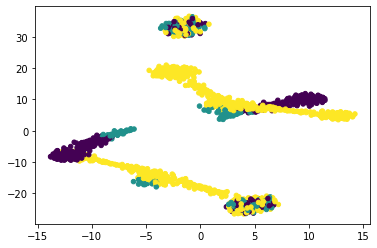

In [880]:
ax = pylab.subplot(111)
ax.scatter(embedding1[:, 0], embedding1[:, 1], 20, timepoint1)
ax.scatter(embedding2[:, 0], embedding2[:, 1], 20, timepoint1)
qqqq = ax.figure.show()

In [881]:
# u1 = pca(embedding1, no_dims=2)

In [882]:
# ax = pylab.subplot(111)
# ax.scatter(u1[:, 0], u1[:, 1], 20, timepoint1)
# ax.figure.show()

In [883]:
# u2 = pca(embedding2, no_dims=2)

In [884]:
# ax = pylab.subplot(111)
# ax.scatter(u2[:, 0], u2[:, 1], 20, timepoint1)
# ax.figure.show()

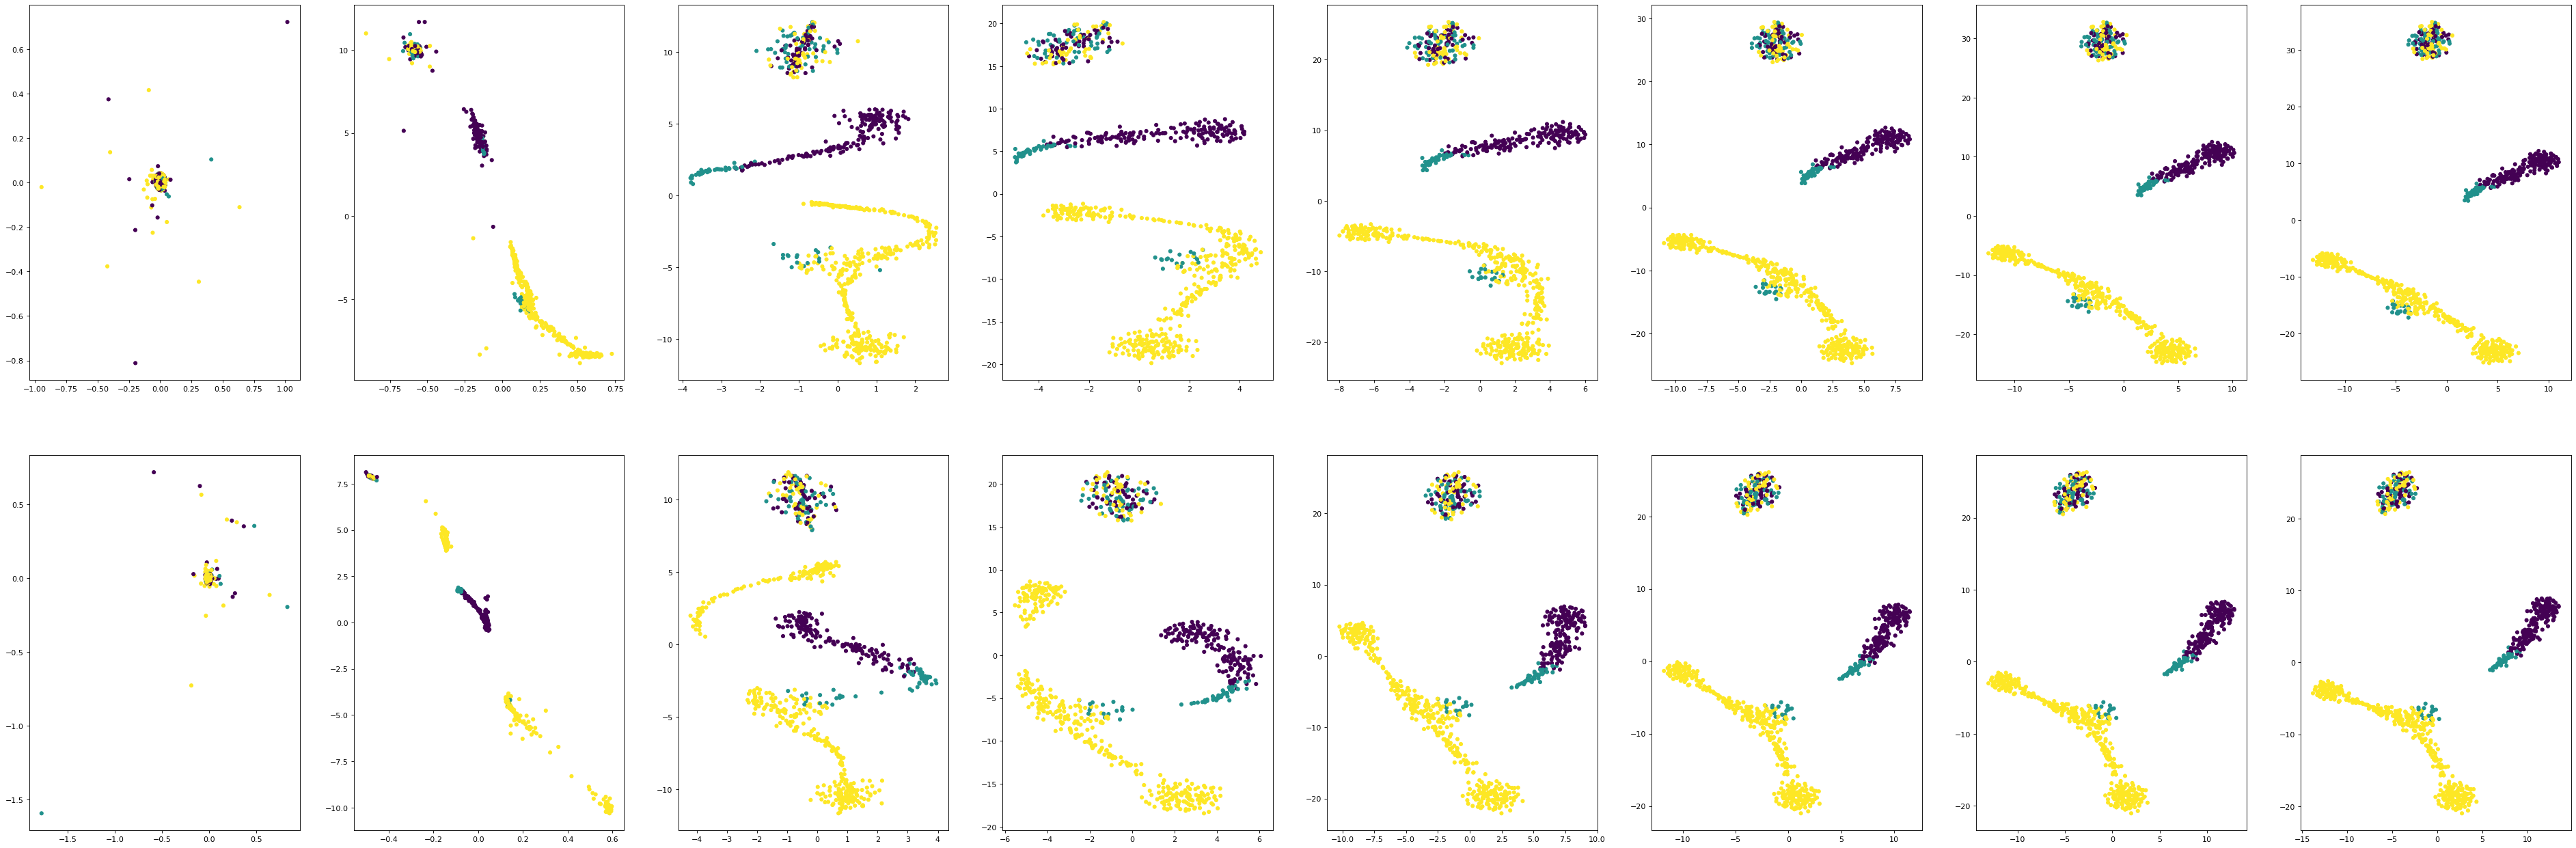

In [889]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(60, 20), dpi=80)  # create a plot figure

k = 62
n_plots = 8
for i in range(n_plots):
    
    plt.subplot(2, n_plots, i+1) # (rows, columns, panel number)
    plt.scatter(ts1.embeddings_after_mmd[i*k+1][:, 0], ts1.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)
    plt.subplot(2, n_plots, i+1+n_plots) # (rows, columns, panel number)
    plt.scatter(-ts2.embeddings_after_mmd[i*k+1][:, 0], -ts2.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)



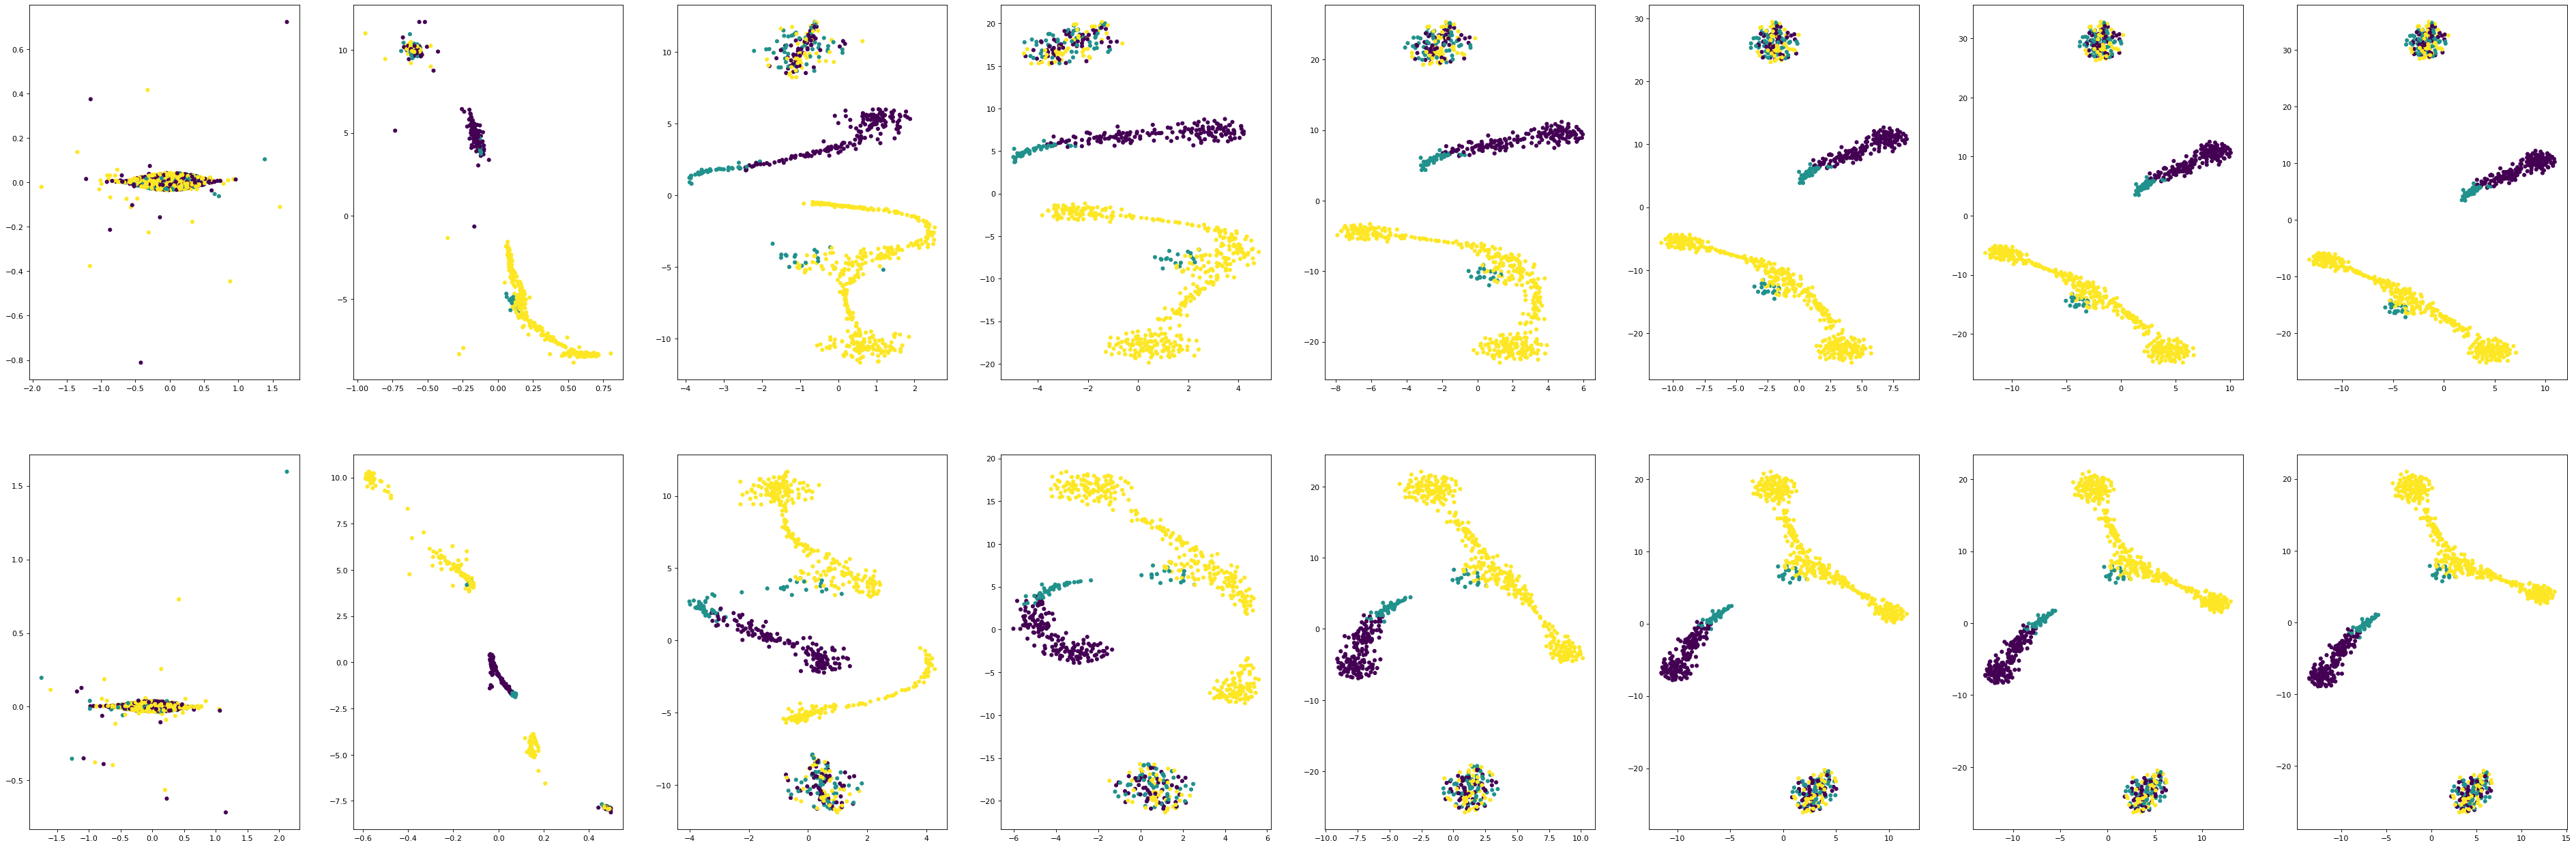

In [886]:
plt.figure(figsize=(60, 20), dpi=80)  # create a plot figure

k = 62
n_plots = 8
for i in range(n_plots):
    
    plt.subplot(2, n_plots, i+1) # (rows, columns, panel number)
    plt.scatter(ts1.embeddings_before_mmd[i*k+1][:, 0], ts1.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)
    plt.subplot(2, n_plots, i+1+n_plots) # (rows, columns, panel number)
    plt.scatter(ts2.embeddings_before_mmd[i*k+1][:, 0], ts2.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)




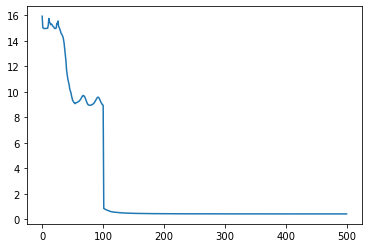

In [856]:
plt.plot(ts1.ce_loss);

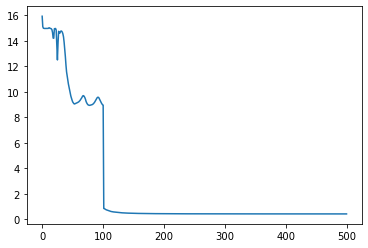

In [857]:
plt.plot(ts2.ce_loss);

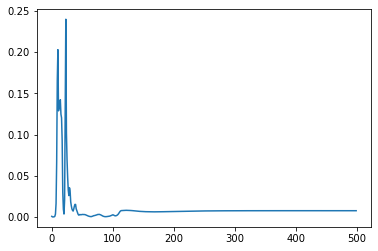

In [858]:
plt.plot(ts2.mmd_loss);

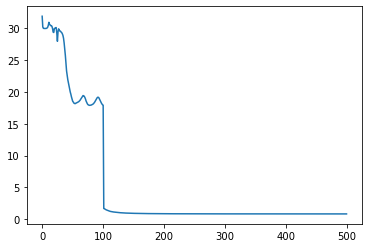

In [859]:
plt.plot((np.array([ts1.mmd_loss]) + np.array([ts1.ce_loss]) + np.array([ts2.ce_loss])).reshape(-1));

In [782]:
proximities = [2**(i-10) for i in range(20)]
for i in range(len(proximities)):
    new_embedding1, new_embedding2, mmd_loss = mmd(ts1.Y, ts2.Y, proximity=proximities[i], ratio=10000)
    print(proximities[i], mmd_loss)

0.0009765625 0.013067420799122376
0.001953125 0.03449521901269814
0.00390625 0.06908906137708348
0.0078125 0.10314049239164413
0.015625 0.1279235018005161
0.03125 0.14249702211129375
0.0625 0.13834194056911325
0.125 0.11683701372665738
0.25 0.0879953310066105
0.5 0.06012861847018709
1 0.037851868202047195
2 0.022482971007033715
4 0.013101832625130922
8 0.007916975242308338
16 0.0052191977364908
32 0.0038446224125591984
64 0.0031589583327378654
128 0.002833551710951802
256 0.002683757397840066
512 0.002610132745535685


In [783]:
new_embedding1, new_embedding2, mmd_loss = mmd(ts1.Y, ts2.Y, proximity=1, ratio=10000)

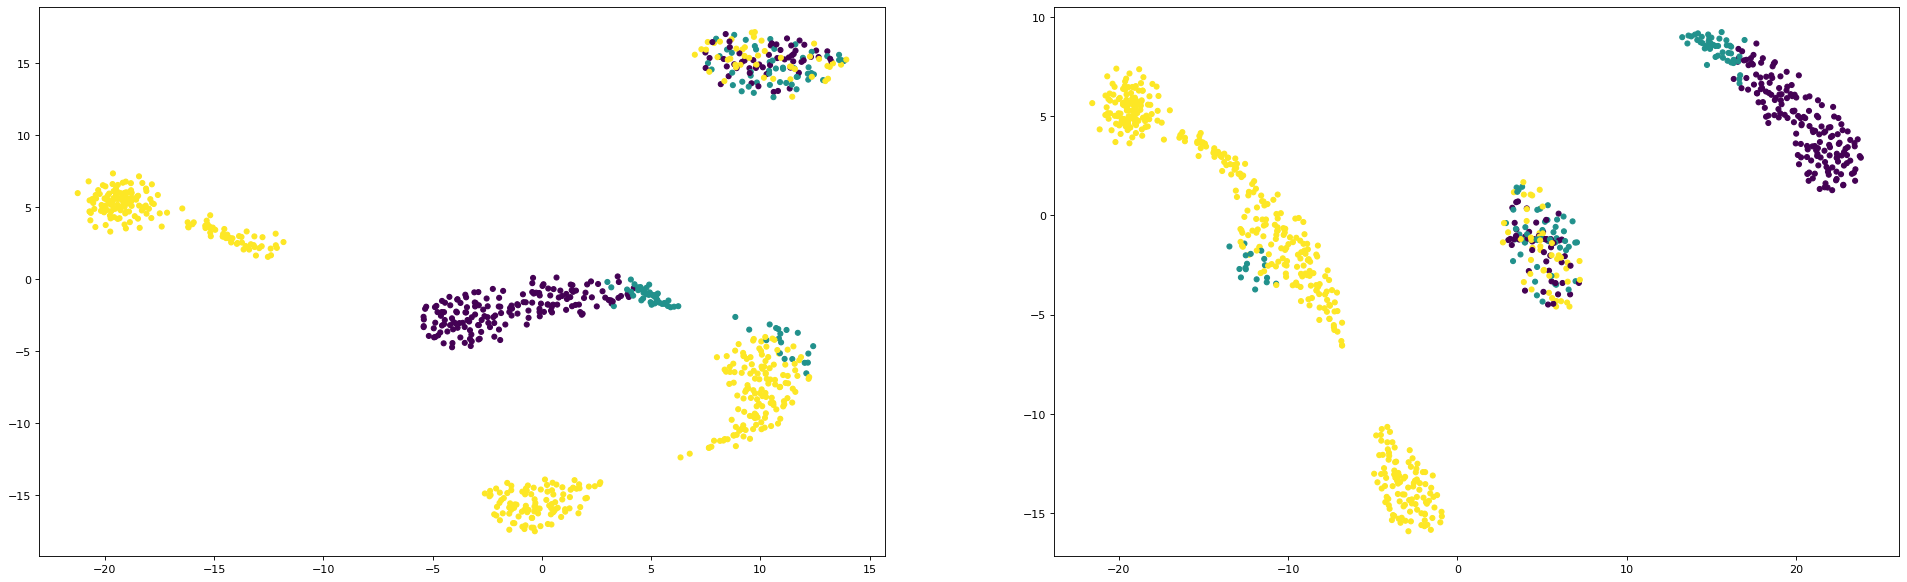

In [784]:
plt.figure(figsize=(30, 20), dpi=80)  # create a plot figure

plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.scatter(new_embedding1[:, 0], new_embedding1[:, 1], 20, timepoint1)
plt.subplot(2, 2, 2) # (rows, columns, panel number)
plt.scatter(new_embedding2[:, 0], new_embedding2[:, 1], 20, timepoint1)

In [785]:
mmd_loss

0.037851868202047195

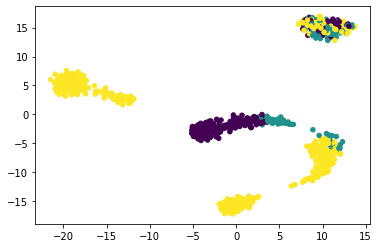

In [786]:
pylab.scatter(embedding1[:, 0], embedding1[:, 1], 20, timepoint1)
pylab.show()

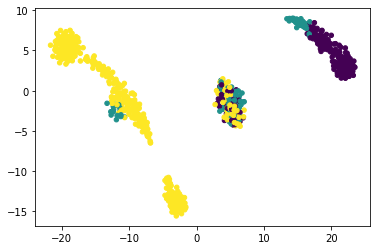

In [787]:
pylab.scatter(embedding2[:, 0], embedding2[:, 1], 20, timepoint1)
pylab.show()

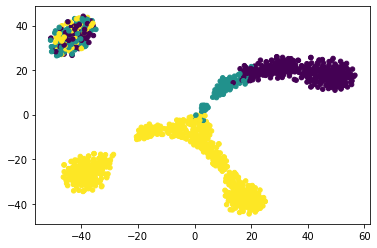

In [53]:
pylab.scatter(ts2.Y[:, 0], ts2.Y[:, 1], 20, timepoint2)
pylab.show()

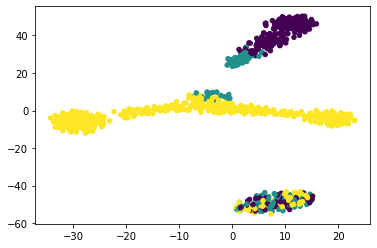

In [33]:
pylab.scatter(ts1.Y[:, 0], ts1.Y[:, 1], 20, timepoint1)
pylab.show()

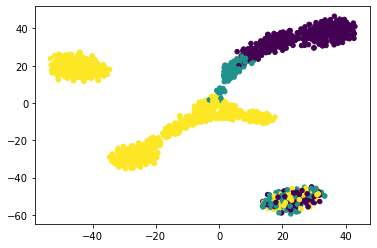

In [34]:
pylab.scatter(ts2.Y[:, 0], ts2.Y[:, 1], 20, timepoint2)
pylab.show()

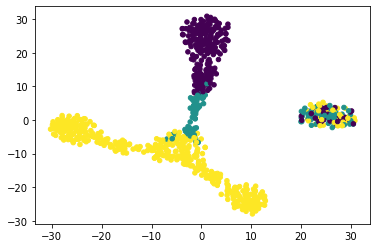

In [25]:
pylab.scatter(ts1.Y[:, 0], ts1.Y[:, 1], 20, timepoint1)
pylab.show()

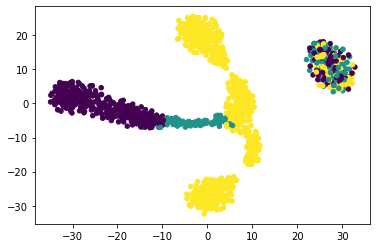

In [26]:
pylab.scatter(ts2.Y[:, 0], ts2.Y[:, 1], 20, timepoint2)
pylab.show()

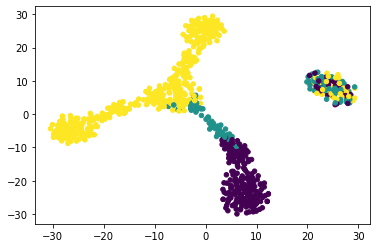

In [22]:
pylab.scatter(ts1.Y[:, 0], ts1.Y[:, 1], 20, timepoint1)
pylab.show()

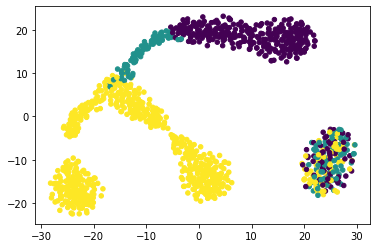

In [23]:
pylab.scatter(ts2.Y[:, 0], ts2.Y[:, 1], 20, timepoint2)
pylab.show()